# List of Keywords we would be interested in (general): 
### (Note that it is impossible to know every subcategory we should expect)
1. Paper
2. Plastic
3. Glass
4. Cardboard
5. Metal
6. Electronic
7. Trash

## Misc....

In [ ]:
import tensorflow as tf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.4,
        rotation_range=90,
        horizontal_flip=True,
        #preprocessing_function = preprocess_image
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)#, preprocessing_function = preprocess_image)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './data/train',  # this is the target directory
       # target_size=(100, 100),  # all images will be resized to 100x100
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        './data/valid',
        #target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        './data/test',
        #target_size=(100, 100),
        batch_size=batch_size, 
        class_mode='categorical')

In [ ]:
def padding(image):
    height = image.shape[0]
    width = image.shape[1]

    left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
    if height > width:
        left_pad = int((height-width) / 2)
        right_pad = height-width-left_pad
    elif width > height:
        top_pad = int((width-height) / 2)
        bottom_pad = width-height-top_pad

    img_square = cv.copyMakeBorder(
        image,
        top_pad,
        bottom_pad,
        left_pad,
        right_pad,
        cv.BORDER_CONSTANT,
        value=(255,255,255)
    )
    return img_square

def toGray(image):
    # toGray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
    # 0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    image[:,:,0] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image[:,:,1] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image[:,:,2] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    return image

def preprocess_image(image):
    #image =toGray(image)
    image = padding(image)
    image_scaled = cv.resize(image, (300, 300))
    #image_scaled = np.true_divide(image_scaled, 255.0)
    #print(image_scaled.shape)
    return image_scaled

In [ ]:
file = 'dataset-original/paper/paper297.jpg'
image = cv.imread(file)
height = image.shape[0]
width = image.shape[1]

left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
if height > width:
    left_pad = int((height-width) / 2)
    right_pad = height-width-left_pad
elif width > height:
    top_pad = int((width-height) / 2)
    bottom_pad = width-height-top_pad

img_square = cv.copyMakeBorder(
    image,
    top_pad,
    bottom_pad,
    left_pad,
    right_pad,
    cv.BORDER_CONSTANT,
    value=(255,255,255)
)
print(img_square.shape[0], img_square.shape[1])
new = padding(image)

In [ ]:
!pip install opencv-python==3.4.2.17 numpy==1.14.5

In [ ]:
import os, sys
import glob
import cv2 as cv
root_dir = "./dataset-original/"
count = 0
total = 2527
for filename in glob.iglob(root_dir + '**/*.jpg', recursive=True):
    count += 1
    print(count,'/',total)
    im = cv.imread(filename)
    pad1 = padding(im)
    new = preprocess_image(im)
    cv.imwrite(filename, new)

In [ ]:
# paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard', 'glass', 'metal','paper', 'plastic', 'trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
# if not os.path.exists(os.path.join('data1','test')):
#     os.makedirs(os.path.join('data1','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-original',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    try:
        ## move source files to train
        train_names = get_names(waste_type,train_ind)
        train_source_files = [os.path.join(source_folder,name) for name in train_names]
        train_dest = "data/train/"+waste_type
        move_files(train_source_files,train_dest)

        ## move source files to valid
        valid_names = get_names(waste_type,valid_ind)
        valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
        valid_dest = "data/valid/"+waste_type
        move_files(valid_source_files,valid_dest)

        ## move source files to test
        test_names = get_names(waste_type,test_ind)
        test_source_files = [os.path.join(source_folder,name) for name in test_names]
        ## I use data/test here because the images can be mixed up
        test_dest = "data/test/"+waste_type
        move_files(test_source_files,test_dest)
    except:
        print('error')
        pass

## Now let's try to use the trashnet model and only use images with the complete object
#### https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

# 1. Extract Data from Bucket

In [ ]:
!gsutil -q cp -r gs://original-data-amli/dataset-original .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/dataset-resized .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/AMLI-trashnet/ .

In [ ]:
!gsutil -q cp -r gs://original-data-amli/AMLI-trashnet 2/ .

In [2]:
!gsutil ls gs://original-data-amli/

gs://original-data-amli/dataset-original.zip
gs://original-data-amli/AMLI-trashnet 2/
gs://original-data-amli/AMLI-trashnet/
gs://original-data-amli/dataset-original/
gs://original-data-amli/dataset-resized/


# 2. Imports and Organize images into different folders

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
# Your code goes here
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import cv2 as cv
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
#Use attached zip file (splits data into train, validation, and testing)

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))


['paper', 'cardboard', 'metal', 'trash', '.DS_Store', 'plastic', 'glass']

In [4]:
## helper functions ##
import random
import shutil
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file,destination_folder)

In [5]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']


In [ ]:

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,test_dest)

In [6]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path


PosixPath('/home/jupyter/Recycling/data')

In [7]:
tfms = get_transforms(do_flip=True,flip_vert=True)
# resize with size = tuple w/ resize method
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [8]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/Recycling/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/Recycling/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/jupyter/Recycling/data

In [9]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


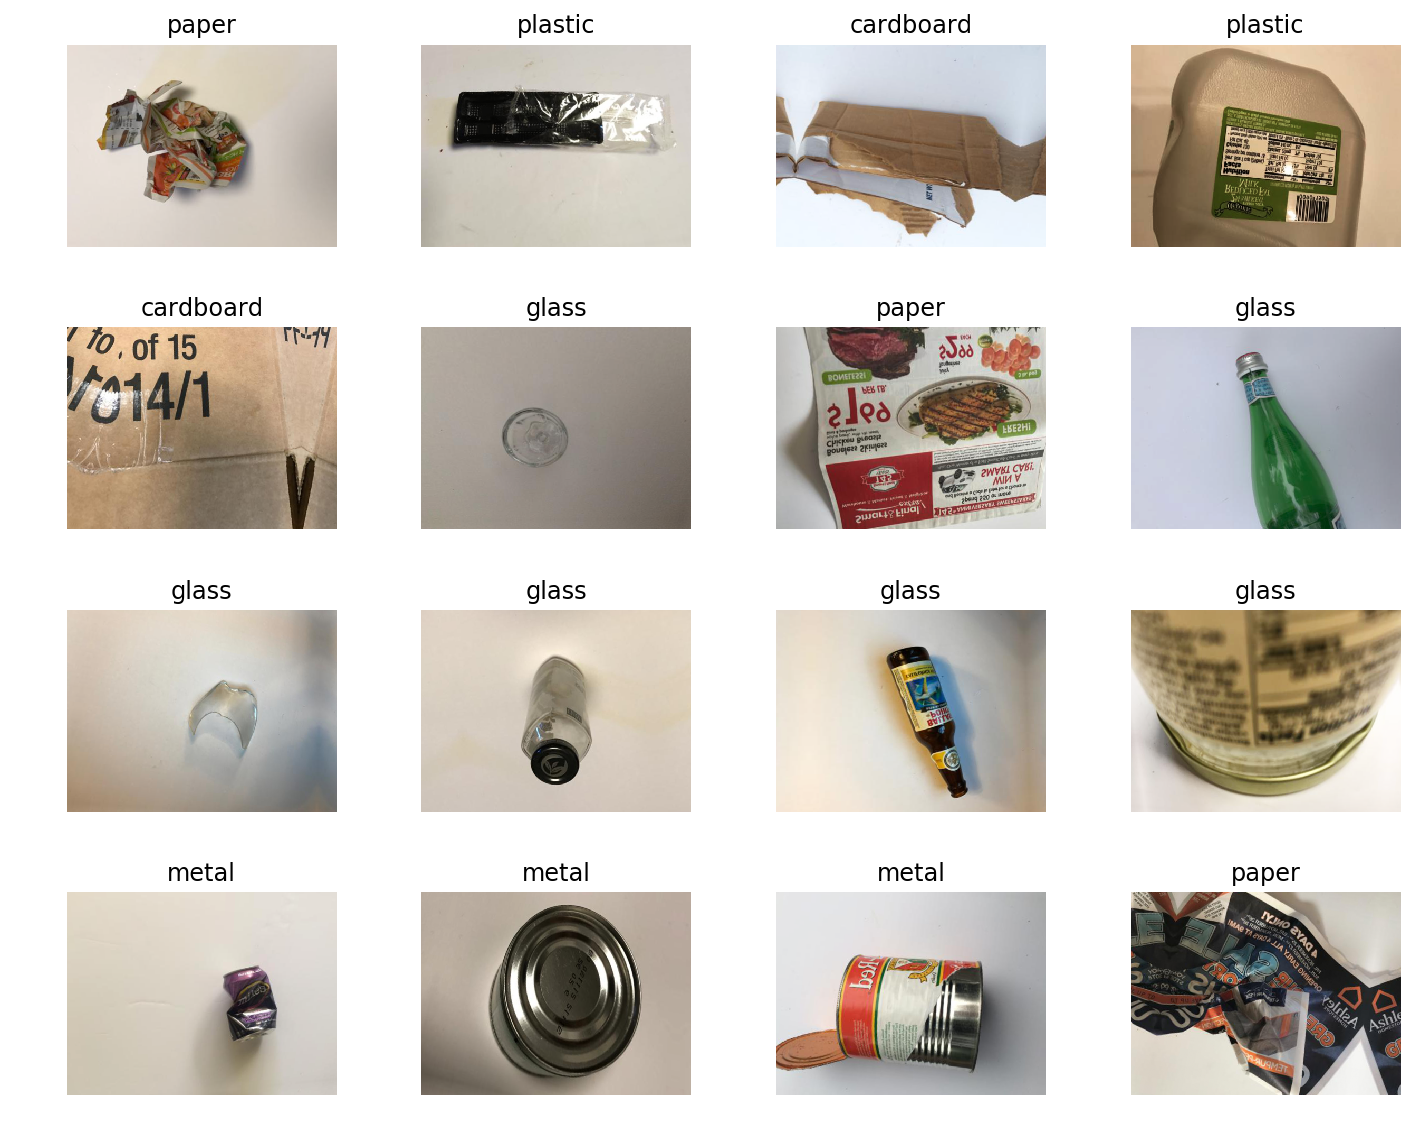

In [10]:
data.show_batch(rows=4,figsize=(10,8))

# 3. Model Training

In [11]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
learn.model

## 3.1 Find the ideal learning rate

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

## 3.2 Training

In [12]:
learn.fit_one_cycle(16,max_lr=5.13e-03)


epoch,train_loss,valid_loss,error_rate,time
0,1.378378,0.713479,0.253968,00:46
1,0.849342,0.485542,0.146032,00:40
2,0.683086,0.567469,0.182540,00:40
3,0.706772,0.616676,0.200000,00:40
4,0.691136,0.548654,0.184127,00:40
5,0.634110,0.662939,0.212698,00:40
6,0.590161,0.457427,0.155556,00:40
7,0.525403,0.355656,0.117460,00:40
8,0.448672,0.346813,0.117460,00:40
9,0.404255,0.319018,0.125397,00:40


## 3.3 VIsualizing most incorrect images¶

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

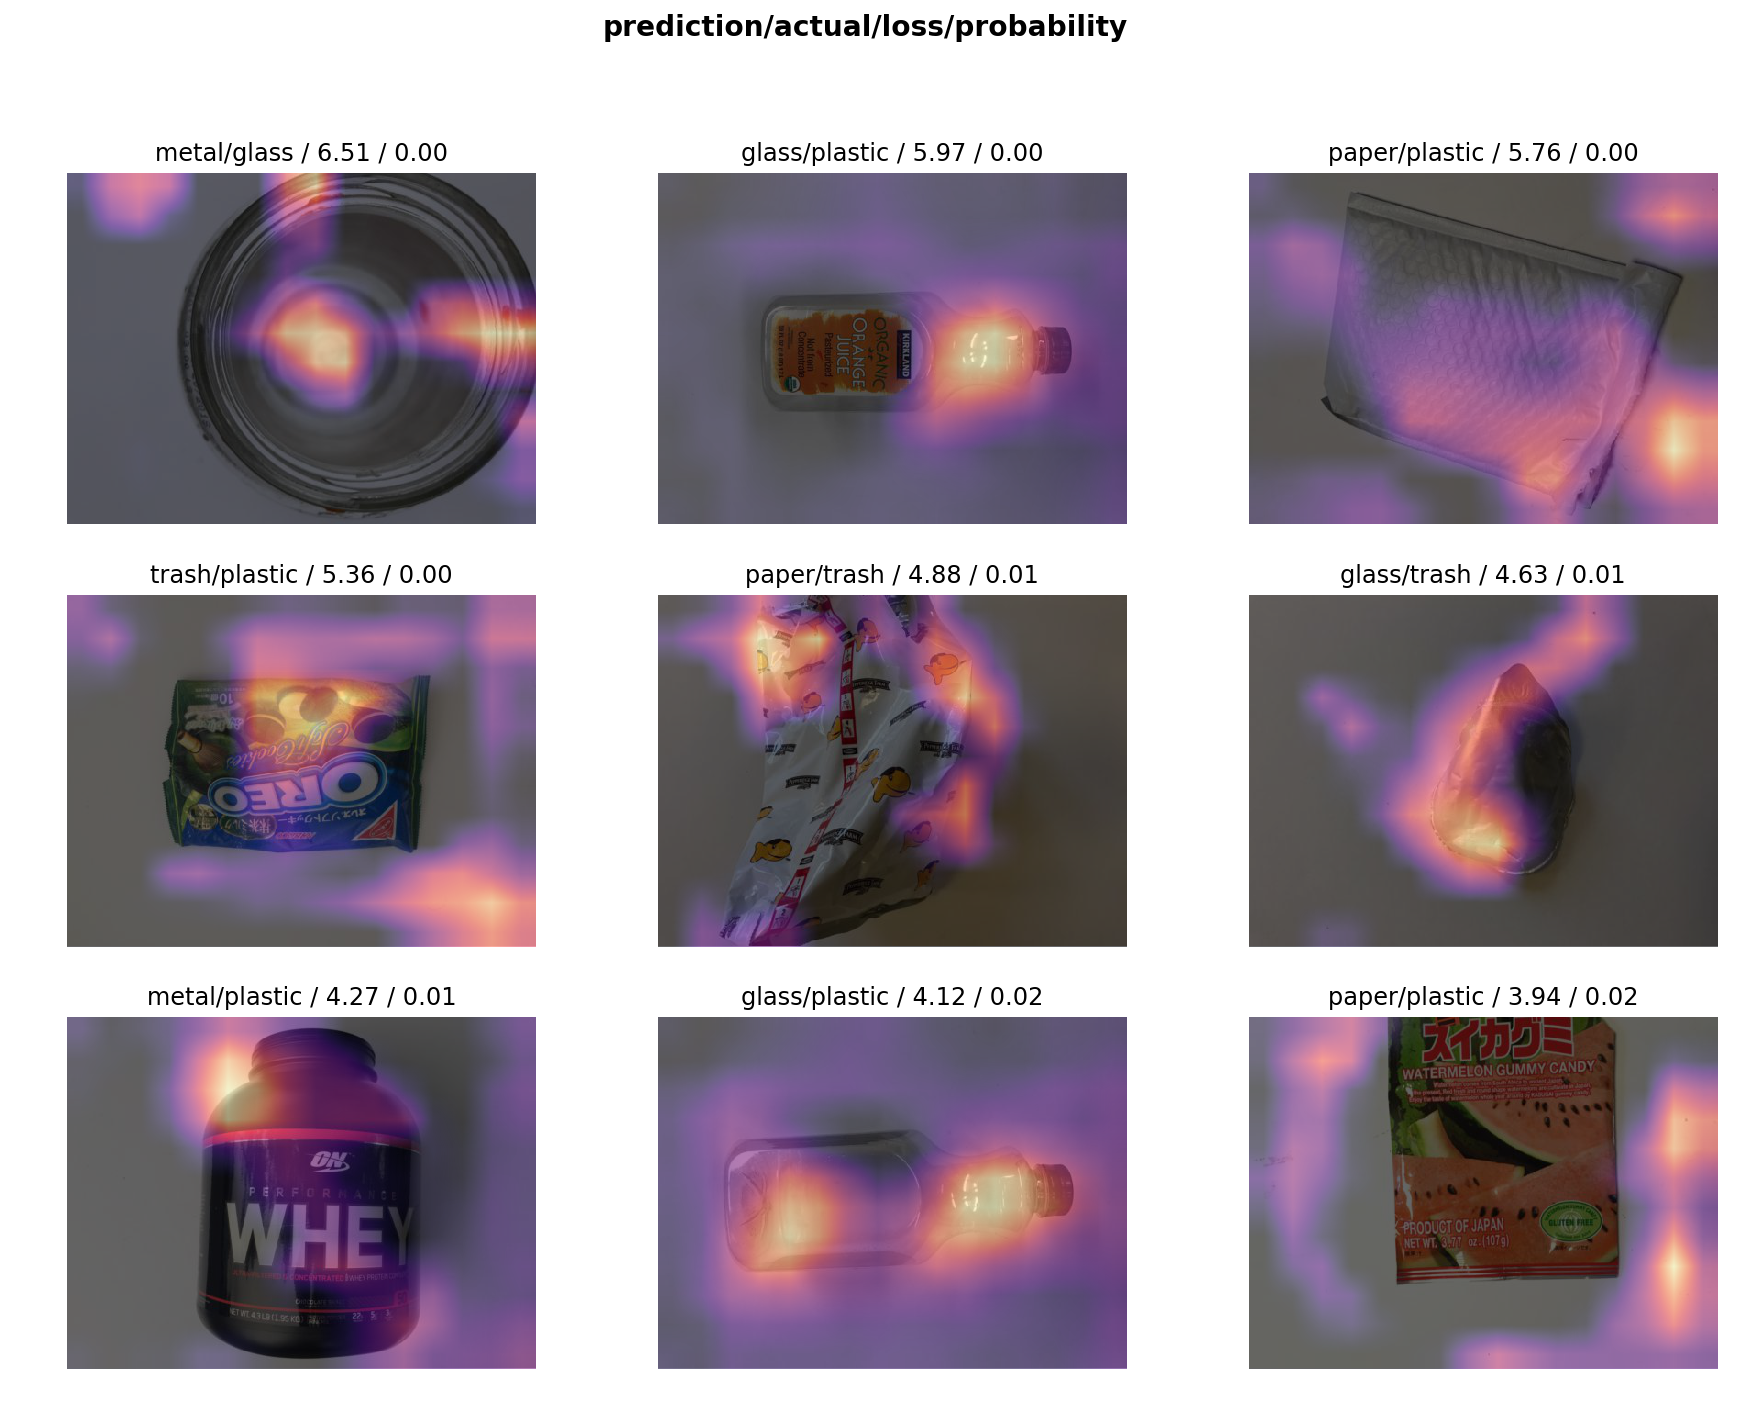

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

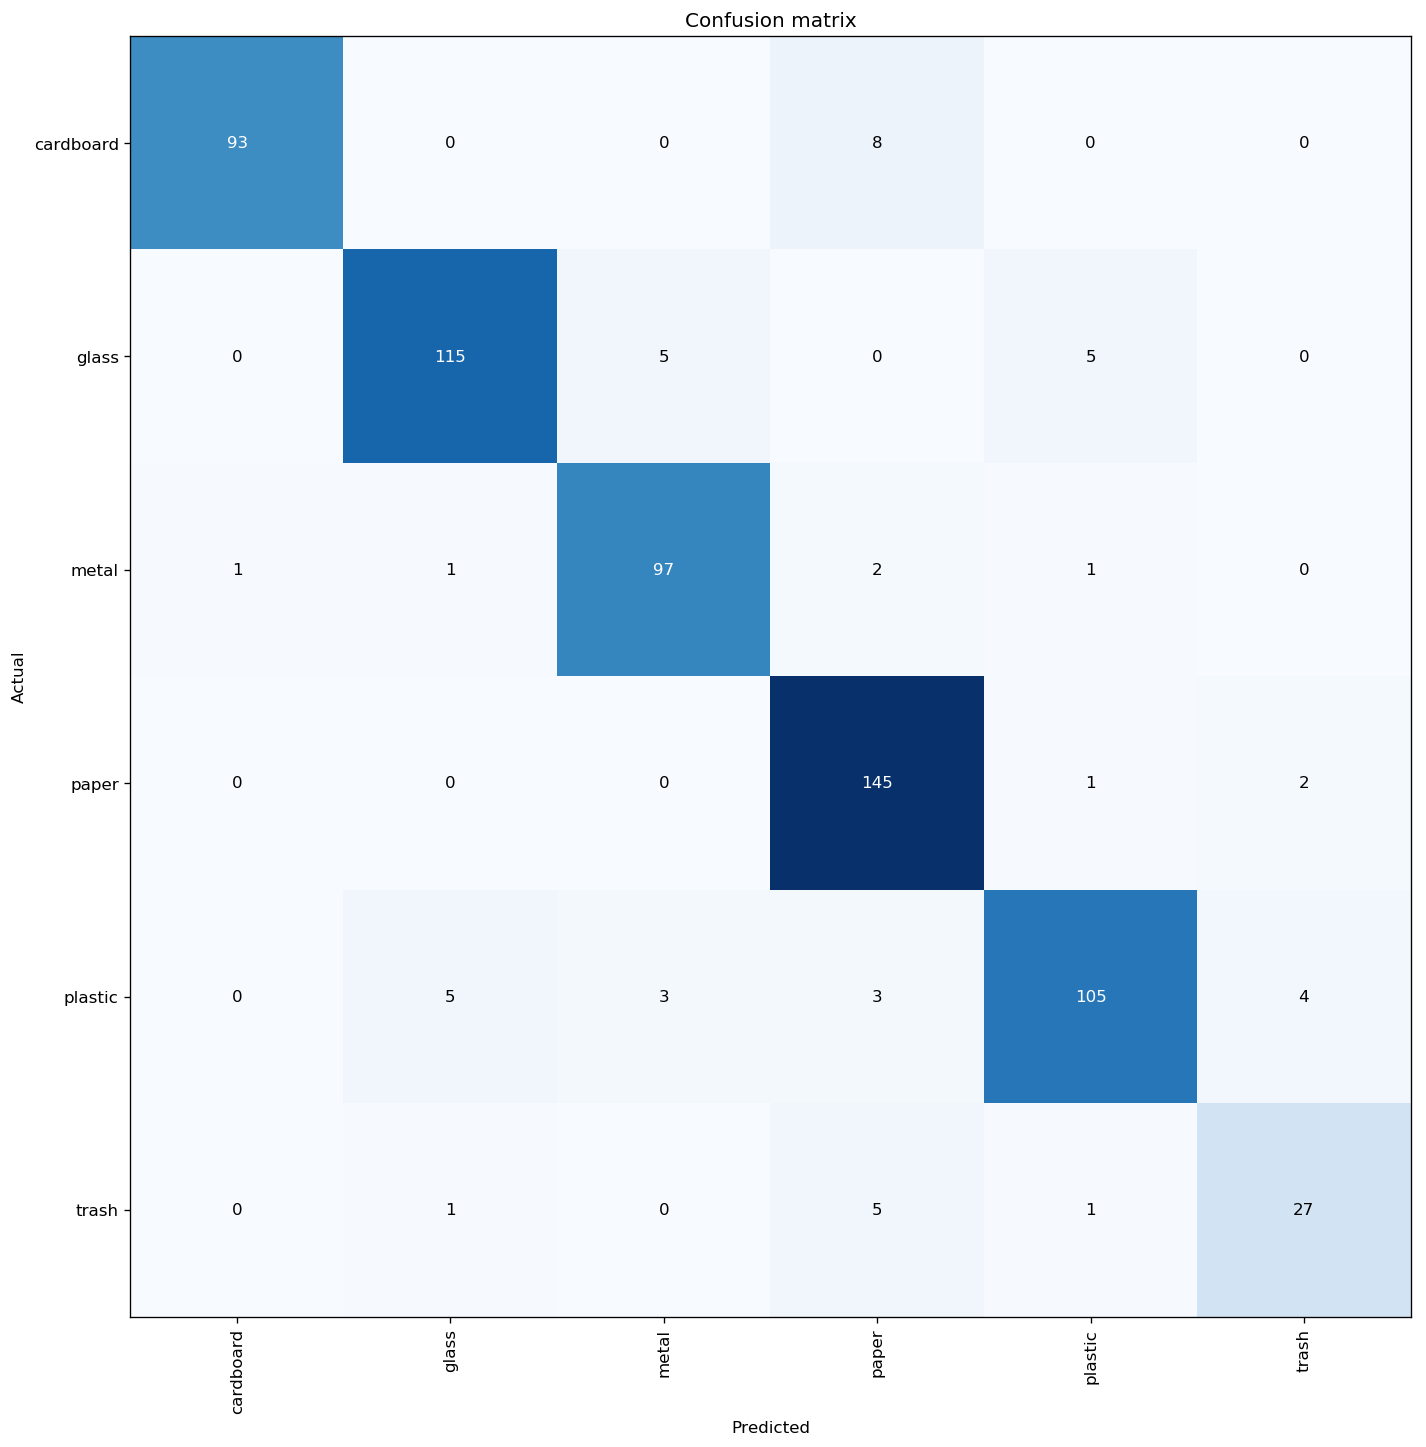

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [15]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('cardboard', 'paper', 8),
 ('glass', 'metal', 5),
 ('glass', 'plastic', 5),
 ('plastic', 'glass', 5),
 ('trash', 'paper', 5),
 ('plastic', 'trash', 4),
 ('plastic', 'metal', 3),
 ('plastic', 'paper', 3),
 ('metal', 'paper', 2),
 ('paper', 'trash', 2)]

## 3.4 Make new predictions on test data

In [17]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [18]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[1.8380e-03, 1.2260e-06, 4.9843e-07, 9.9757e-01, 5.8792e-06, 5.8833e-04],
        [1.6929e-03, 3.8461e-07, 6.6828e-05, 9.9807e-01, 2.7199e-06, 1.6526e-04],
        [8.8114e-05, 6.6070e-07, 5.5148e-06, 9.9990e-01, 8.1167e-07, 6.6658e-07],
        ...,
        [7.2717e-05, 9.9885e-01, 1.3826e-05, 9.0633e-05, 9.2761e-04, 4.0628e-05],
        [1.9990e-04, 9.7097e-01, 1.9077e-02, 6.9400e-05, 9.5993e-03, 7.9997e-05],
        [3.3618e-04, 9.9419e-01, 5.3006e-03, 3.1505e-05, 1.2873e-04, 8.8844e-06]])

In [19]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [20]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [21]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [22]:
yhat[:5]

['paper', 'paper', 'paper', 'paper', 'paper']

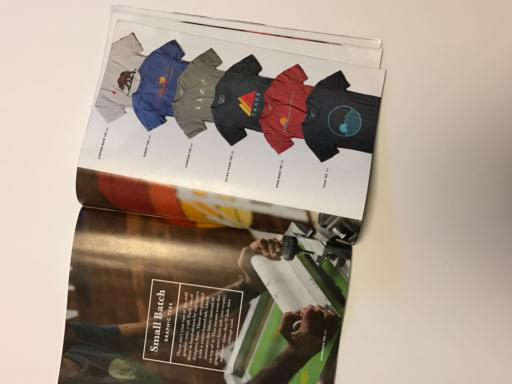

In [23]:
learn.data.test_ds[0][0]

In [24]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
        
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [25]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['paper', 'paper', 'paper', 'paper', 'paper']
['paper', 'paper', 'paper', 'paper', 'paper']


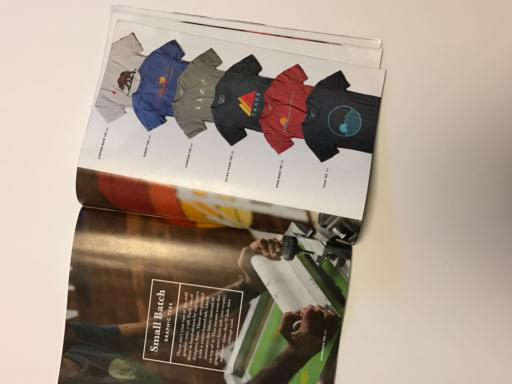

In [26]:
learn.data.test_ds[0][0]

In [27]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 96   0   1   4   0   0]
 [  0 113   8   2   3   0]
 [  1   9  90   0   1   2]
 [  0   0   1 147   0   1]
 [  0   4   0   0 114   3]
 [  1   1   0   4   2  27]]


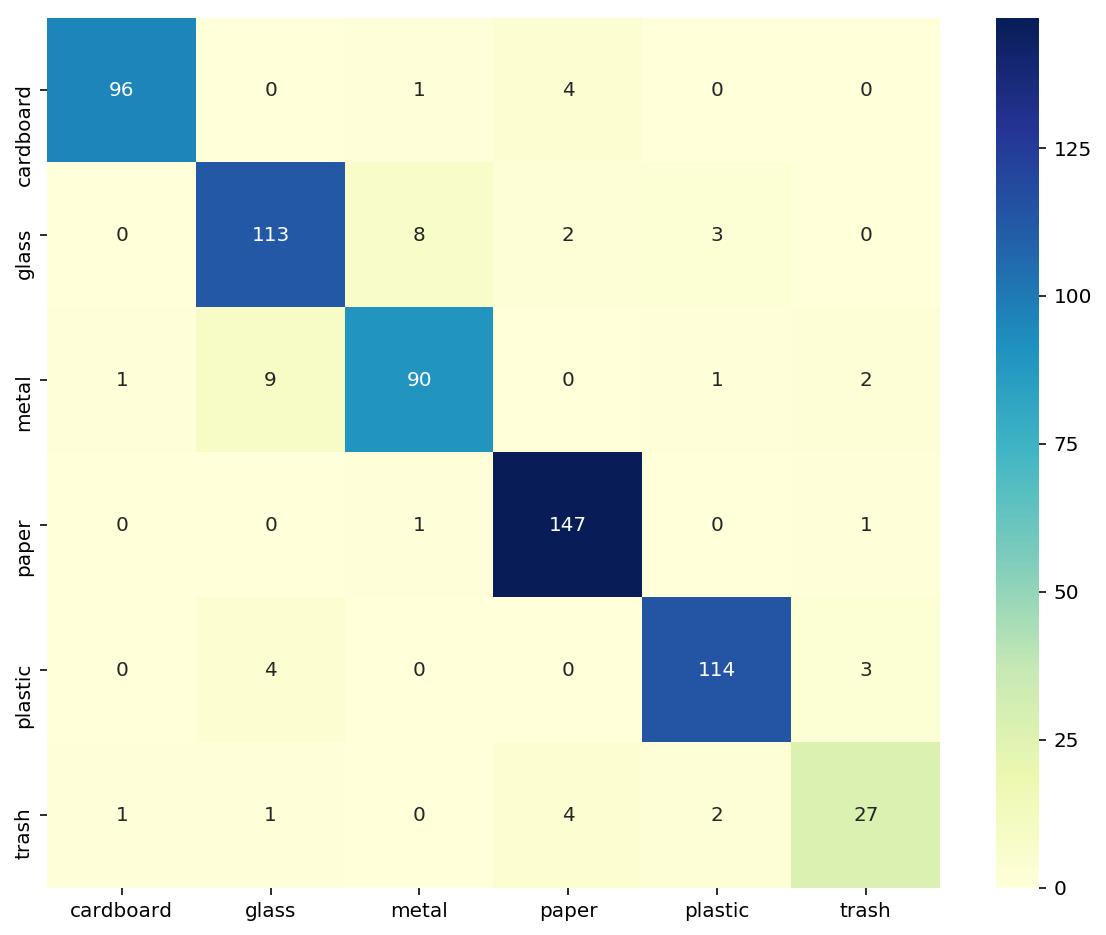

In [28]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [29]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [30]:
accuracy = correct/sum(sum(cm))
accuracy

0.9244094488188976

In [31]:
# ## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

## 1.5 AMLI-trashnet Preprocessing

### Photos only first (Ignore Video folders)

In [ ]:
def rename(waste): 
    i = 0
    file = os.path.join('AMLI-trashnet/', waste, 'Photo')
    for filename in os.listdir(file): 
        dst = waste + str(i) + ".jpg"
        src =file+'/'+ filename 
        dst =file+ '/' + dst 
        os.rename(src, dst) 
        i += 1
#rename('Trash')

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']

for waste in waste_types:
    rename(waste)

In [ ]:
## helper functions ##
import random
import shutil
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(0,n))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(0,n)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file,destination_folder)

In [ ]:
## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('new_data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
for waste_type in waste_types:
    source_folder = os.path.join('AMLI-trashnet',waste_type, 'Photo')
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    print(waste_type)
    print('train', train_ind)
    print('val', valid_ind)
    print('test', test_ind)

In [ ]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('AMLI-trashnet',waste_type, 'Photo')
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "new_data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "new_data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "new_data/test/"+waste_type
#     ## I use data/test here because the images can be mixed up
    move_files(test_source_files,test_dest)

In [32]:
## get a path to the folder with images
path = Path(os.getcwd())/"new_data"
path

PosixPath('/home/jupyter/Recycling/new_data')

In [33]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",bs=16, no_check=True)
data.classes.append('Trash')

In [34]:
data.classes

['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

In [35]:
learn.data = data

In [38]:
preds = learn.get_preds(ds_type=DatasetType.Test)

RuntimeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/anaconda3/lib/python3.7/site-packages/fastai/torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 43, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 3024 and 2448 in dimension 2 at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/TH/generic/THTensor.cpp:711


In [ ]:
print(preds.shape)

In [ ]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
print(max_idxs[7])

In [ ]:
yhat = []
for max_idx in max_idxs:
    print(max_idx)
    print(data.classes[max_idx])
    yhat.append(data.classes[max_idx])

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

In [ ]:
learn.data.test_ds[0][0]

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

In [ ]:
data.classes